In [26]:
import pandas as pd

pop_il = pd.read_csv("IL_population_2024.csv", skiprows=3)

pop_il.head()
pop_il.columns


Index(['Unnamed: 0', 'Unnamed: 1', '2020', '2021', '2022', '2023', '2024'], dtype='object')

In [27]:
import pandas as pd

pop_il = pd.read_csv("IL_population_2024.csv", skiprows=3)

print(pop_il.columns.tolist())
print(pop_il.head())

geo_col = pop_il.columns[0]         
col_2024 = [c for c in pop_il.columns if "2024" in str(c)][0]   


pop_il = pop_il.rename(columns={
    geo_col: "geographic_area",
    col_2024: "population_2024"
})

pop_il = pop_il[~pop_il["geographic_area"].isna()].copy()

pop_il = pop_il[pop_il["geographic_area"].str.contains(",", na=False)].copy()

pop_il[["city", "state"]] = pop_il["geographic_area"].str.split(",", n=1, expand=True)
pop_il["city"] = pop_il["city"].str.strip().str.title()
pop_il["state"] = pop_il["state"].str.strip().str.title()

pop_il["population_2024"] = (
    pop_il["population_2024"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
)
pop_il["population_2024"] = pd.to_numeric(pop_il["population_2024"], errors="coerce")

pop_il_clean = pop_il[["state", "city", "population_2024"]].copy()

pop_il_clean.to_csv("il_population_2024_clean.csv", index=False)
pop_il_clean.head()



['Unnamed: 0', 'Unnamed: 1', '2020', '2021', '2022', '2023', '2024']
                     Unnamed: 0 Unnamed: 1    2020    2021    2022    2023  \
0       Abingdon city, Illinois      2,958   2,949   2,915   2,873   2,868   
1  Addieville village, Illinois        258     257     255     257     255   
2     Addison village, Illinois     35,696  35,631  35,387  35,243  35,420   
3     Adeline village, Illinois         76      76      76      75      75   
4      Albany village, Illinois        863     861     858     849     852   

     2024  
0   2,871  
1     253  
2  35,728  
3      75  
4     851  


,state,city,population_2024
0,Illinois,Abingdon City,2871.0
1,Illinois,Addieville Village,253.0
2,Illinois,Addison Village,35728.0
3,Illinois,Adeline Village,75.0
4,Illinois,Albany Village,851.0


In [28]:
import pandas as pd
import re
aqs_city_daily = (
    pd.read_csv("aqs_il_pm25_20240101.csv", parse_dates=["date_local"])
      .rename(columns={"arithmetic_mean": "pm25_mean"})
)

pop_il_clean = pd.read_csv("il_population_2024_clean.csv")

def normalize_city(name: str) -> str:
    name = str(name).strip()
    name = re.sub(r"\s+\(.*\)$", "", name)

    name = re.sub(r"\s+(city|village|town|cdp)$", "", name, flags=re.IGNORECASE)
    return name.title()

aqs_city_daily["city_norm"] = aqs_city_daily["city"].apply(normalize_city)
aqs_city_daily["state"] = aqs_city_daily["state"].astype(str).str.strip().str.title()

pop_il_clean["city_norm"] = pop_il_clean["city"].apply(normalize_city)
pop_il_clean["state"] = pop_il_clean["state"].astype(str).str.strip().str.title()

print("Unique AQS cities (normalized) sample:")
print(sorted(aqs_city_daily["city_norm"].unique())[:15], "\n")

print("Unique population cities (normalized) sample:")
print(sorted(pop_il_clean["city_norm"].unique())[:15], "\n")

merged = pd.merge(
    aqs_city_daily,
    pop_il_clean,
    on=["state", "city_norm"],
    how="inner",
    suffixes=("_aqs", "_pop")
)

print("Merged shape:", merged.shape)
print("Example cities:", merged["city_norm"].unique()[:15], "\n")

print("Merged preview:")
print(
    merged[["state", "city_norm", "date_local", "pm25_mean", "population_2024"]]
        .head()
)

merged.to_csv("pm25_population_merged_20240101_v3.csv", index=False)
print("\nSaved to pm25_population_merged_20240101_v3.csv")


Unique AQS cities (normalized) sample:
['Alsip', 'Alton', 'Aurora', 'Bondville', 'Braidwood', 'Cary', 'Champaign', 'Chicago', 'Cicero', 'Decatur', 'Des Plaines', 'East Saint Louis', 'Granite', 'Jerseyville', 'Joliet'] 

Unique population cities (normalized) sample:
['Abingdon', 'Addieville', 'Addison', 'Adeline', 'Albany', 'Albers', 'Albion', 'Aledo', 'Alexis', 'Algonquin', 'Alhambra', 'Allendale', 'Allenville', 'Allerton', 'Alma'] 

Merged shape: (248, 35)
Example cities: ['Champaign' 'Summit' 'Alsip' 'Northbrook' 'Chicago' 'Cicero' 'Aurora'
 'Bondville' 'Schiller Park' 'Jerseyville' 'Normal' 'Peoria' 'Alton'
 'Lansing' 'Des Plaines'] 

Merged preview:
      state  city_norm date_local  pm25_mean  population_2024
0  Illinois  Champaign 2024-01-01        1.8          91961.0
1  Illinois  Champaign 2024-01-01        1.8          91961.0
2  Illinois  Champaign 2024-01-01        1.8          91961.0
3  Illinois  Champaign 2024-01-01        1.8          91961.0
4  Illinois  Champaign 2024-

In [29]:
city_summary = (
    merged
    .groupby(["city_norm"], as_index=False)
    .agg(
        pm25_mean=("pm25_mean", "mean"),
        population_2024=("population_2024", "first"),
        n_obs=("pm25_mean", "size")
    )
)

print("City summary shape:", city_summary.shape)
city_summary.head()
city_summary.to_csv("city_pm25_population_summary_20240101.csv", index=False)


City summary shape: (22, 4)


In [30]:
city_summary[["pm25_mean", "population_2024"]].corr()

,pm25_mean,population_2024
pm25_mean,1.000000,-0.270211
population_2024,-0.270211,1.000000


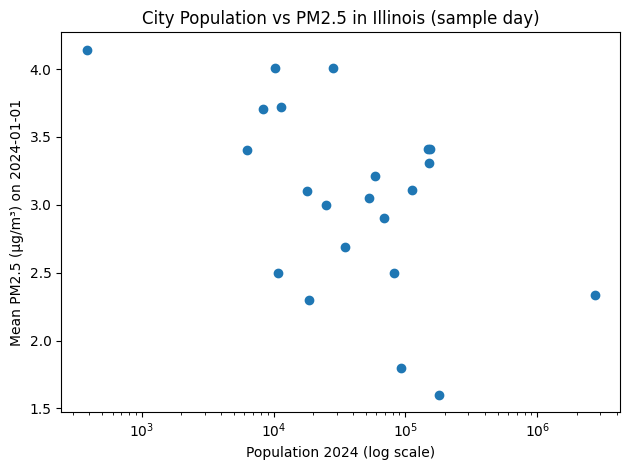

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(city_summary["population_2024"], city_summary["pm25_mean"])
plt.xscale("log")
plt.xlabel("Population 2024 (log scale)")
plt.ylabel("Mean PM2.5 (µg/m³) on 2024-01-01")
plt.title("City Population vs PM2.5 in Illinois (sample day)")
plt.tight_layout()
plt.savefig("fig_city_population_vs_pm25_20240101.png", dpi=300)
plt.show()

